In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance
from PIL import Image, ImageDraw

import joblib
import shap
import category_encoders as ce
import xgboost as xgb

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint, LambdaCallback
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout, Bidirectional, GRU
from keras.layers import MaxPooling1D, Flatten, Conv1D

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

2024-11-10 09:44:31.648951: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
df_nasdaq = pd.read_csv('df_nasdaq.csv')
df_sp500 = pd.read_csv('df_sp500.csv')
df_dji = pd.read_csv('df_dji.csv')

In [3]:
stocks = {'df_nasdaq': df_nasdaq, 'df_sp500': df_sp500, 'df_dji': df_dji}

for name, df in stocks.items():
    print(f'Shape of {name}: {df.shape}')

Shape of df_nasdaq: (1372, 19)
Shape of df_sp500: (1372, 19)
Shape of df_dji: (1372, 19)


## Feature Importance

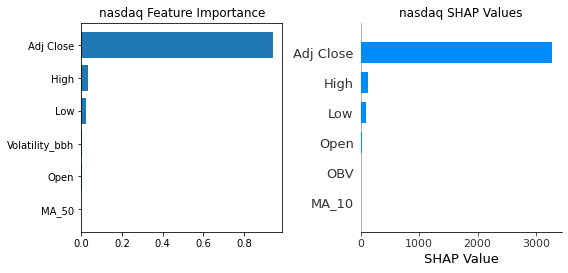

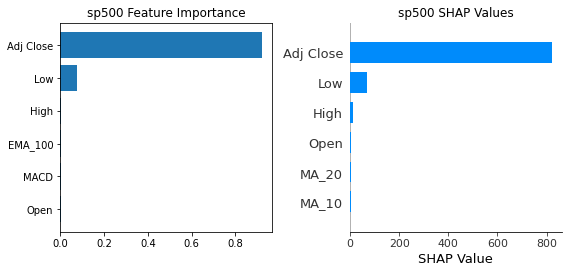

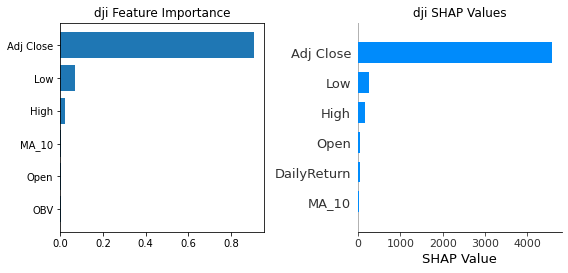

In [26]:
target = 'Close'
stock_name = {'nasdaq': df_nasdaq, 'sp500': df_sp500, 'dji': df_dji}

n_top_features = 6

for stock in stock_name.keys():
    
    df = stock_name[stock]
    y = df[target]
    X = df.drop(columns=[target, 'Date'])
    
    train_size = int(len(df) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    
    encoder = ce.LeaveOneOutEncoder(return_df=True)
    X_train_loo = encoder.fit_transform(X_train, y_train)
    X_test_loo = encoder.transform(X_test)
    
    model = xgb.XGBRegressor(n_estimators=500, max_depth=5, eta=0.05)
    model.fit(X_train_loo, y_train)
      
    filename = f"xgb/{stock}_xgb_model.sav"
    joblib.dump(model, filename)
    
    feature_importance = model.feature_importances_
    sorted_idx = np.argsort(feature_importance)
    
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].barh(range(n_top_features), feature_importance[sorted_idx[-n_top_features:]])
    axs[0].set_title(f'{stock} Feature Importance')
    axs[0].set_yticks(range(n_top_features))
    axs[0].set_yticklabels(np.array(X_test_loo.columns)[sorted_idx[-n_top_features:]])
    
    explainer = shap.Explainer(model)
    shap_values = explainer(X_test_loo)
    
    shap.summary_plot(shap_values, X_test_loo, plot_type="bar", feature_names=X_test_loo.columns,
                      max_display=n_top_features, show=False)
    
    axs[1].set_title(f'{stock} SHAP Values')
    axs[1].set_xlabel('SHAP Value')
    
    plt.tight_layout()
    plt.show()

### Loss of Nasdaq without XGB

In [4]:
def split_data(stock):
    stock = stock.to_numpy()
    test_set_size = int(np.round(0.2 * len(stock)))
    val_set_size = int(np.round(0.2 * len(stock)))
    train_set_size = len(stock) - test_set_size - val_set_size
    
    train = stock[:train_set_size, :]
    val = stock[train_set_size: train_set_size+val_set_size, :]
    test = stock[train_set_size+val_set_size:, :]

    return (train, val, test)

In [5]:
train, val, test = split_data(df_nasdaq.drop(columns=['Date']))

In [6]:
# Standardize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(train)
scaled_val = scaler.transform(val)
scaled_test = scaler.transform(test)

print(f'Shape of scaled training Set: {scaled_train.shape}')
print(f'Shape of scaled training Set: {scaled_val.shape}')
print(f'Shape of scaled testing Set: {scaled_test.shape}')

Shape of scaled training Set: (824, 18)
Shape of scaled training Set: (274, 18)
Shape of scaled testing Set: (274, 18)


In [7]:
def createXY(dataset,lookback):
    dataX = []
    dataY = []
    for i in range(lookback, len(dataset)):
            dataX.append(dataset[i - lookback:i, 0:dataset.shape[1]])
            dataY.append(dataset[i,0])
    return np.array(dataX),np.array(dataY)

lookback = 30

X_train, y_train = createXY(scaled_train,lookback)
X_val, y_val = createXY(scaled_val,lookback)
X_test, y_test = createXY(scaled_test,lookback)

print(f"shape of X_train:{np.shape(X_train)}, shape of y_train:{np.shape(y_train)}")
print(f"shape of X_train:{np.shape(X_val)}, shape of y_train:{np.shape(y_val)}")
print(f"shape of X_test:{np.shape(X_test)}, shape of y_test:{np.shape(y_test)}")

shape of X_train:(794, 30, 18), shape of y_train:(794,)
shape of X_train:(244, 30, 18), shape of y_train:(244,)
shape of X_test:(244, 30, 18), shape of y_test:(244,)


In [8]:
# LSTM Training
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='Adam', metrics=['mse', 'mae'])
model.summary()

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=16)

model.save('xgb/nasdaq_lstm_model_without_xgb.h5')
print("Model saved at 'xgb/nasdaq_lstm_model_without_xgb.h5'")

# Prediction
y_pred = model.predict(X_test)
y_pred_copies_array = np.repeat(y_pred, X_train.shape[2], axis=-1) # the length of feature and target
y_pred_inversed = scaler.inverse_transform(y_pred_copies_array)[:, 0]

y_test_copies_array = np.repeat(y_test.reshape(-1, 1), X_train.shape[2], axis=-1)
y_test_inversed = scaler.inverse_transform(y_test_copies_array)[:,0]

# Convert y_pred_inversed to a dataframe and save as a csv file
results_df = pd.DataFrame({'test': y_test_inversed,'lstm': y_pred_inversed})
results_df.to_csv('xgb/nasdaq_lstm_predictions_without_xgb.csv', index=False)

2024-11-09 10:44:57.739682: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-11-09 10:44:57.746550: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-11-09 10:44:57.746840: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-11-09 10:44:57.747431: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the approp

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 50)            13800     
                                                                 
 dropout (Dropout)           (None, 30, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 34,051
Trainable params: 34,051
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50


2024-11-09 10:45:02.152131: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101


 1/50 [..............................] - ETA: 3:13 - loss: 0.2978 - mse: 0.2978 - mae: 0.4937

2024-11-09 10:45:02.860143: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


50/50 [==============================] - 5s 19ms/step - loss: 0.0248 - mse: 0.0248 - mae: 0.1079 - val_loss: 0.0123 - val_mse: 0.0123 - val_mae: 0.0893
Epoch 2/50
50/50 [==============================] - 0s 6ms/step - loss: 0.0070 - mse: 0.0070 - mae: 0.0625 - val_loss: 0.0058 - val_mse: 0.0058 - val_mae: 0.0598
Epoch 3/50
50/50 [==============================] - 0s 7ms/step - loss: 0.0057 - mse: 0.0057 - mae: 0.0565 - val_loss: 0.0062 - val_mse: 0.0062 - val_mae: 0.0611
Epoch 4/50
50/50 [==============================] - 0s 7ms/step - loss: 0.0051 - mse: 0.0051 - mae: 0.0538 - val_loss: 0.0049 - val_mse: 0.0049 - val_mae: 0.0545
Epoch 5/50
50/50 [==============================] - 0s 6ms/step - loss: 0.0046 - mse: 0.0046 - mae: 0.0516 - val_loss: 0.0035 - val_mse: 0.0035 - val_mae: 0.0459
Epoch 6/50
50/50 [==============================] - 0s 7ms/step - loss: 0.0041 - mse: 0.0041 - mae: 0.0479 - val_loss: 0.0043 - val_mse: 0.0043 - val_mae: 0.0511
Epoch 7/50
50/50 [====================

In [9]:
# Bi-LSTM Training
model = Sequential()
model.add(Bidirectional(LSTM(50, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(50)))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='Adam', metrics=['mse', 'mae'])
model.summary()

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=16)

model.save('xgb/nasdaq_bi-lstm_model_without_xgb.h5')
print("Model saved at 'xgb/nasdaq_bi-lstm_model_without_xgb.h5'")

# Prediction
y_pred = model.predict(X_test)
y_pred_copies_array = np.repeat(y_pred, X_train.shape[2], axis=-1) # the length of feature and target
y_pred_inversed = scaler.inverse_transform(y_pred_copies_array)[:, 0]

y_test_copies_array = np.repeat(y_test.reshape(-1, 1), X_train.shape[2], axis=-1)
y_test_inversed = scaler.inverse_transform(y_test_copies_array)[:,0]

# Convert y_pred_inversed to a dataframe and save as a csv file
results_df = pd.DataFrame({'test': y_test_inversed,'lstm': y_pred_inversed})
results_df.to_csv('xgb/nasdaq_bi-lstm_predictions_without_xgb.csv', index=False)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 30, 100)          27600     
 l)                                                              
                                                                 
 dropout_2 (Dropout)         (None, 30, 100)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 100)              60400     
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 88,101
Trainable params: 88,101
Non-trai

In [10]:
# CNN-LSTM Training
model = Sequential()

model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(2))
# Don't need flatten

model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='Adam', metrics=['mse', 'mae'])
model.summary()

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=16)

model.save('xgb/nasdaq_cnn-lstm_model_without_xgb.h5')
print("Model saved at 'xgb/nasdaq_cnn-lstm_model_without_xgb.h5'")

# Prediction
y_pred = model.predict(X_test)
y_pred_copies_array = np.repeat(y_pred, X_train.shape[2], axis=-1) # the length of feature and target
y_pred_inversed = scaler.inverse_transform(y_pred_copies_array)[:, 0]

y_test_copies_array = np.repeat(y_test.reshape(-1, 1), X_train.shape[2], axis=-1)
y_test_inversed = scaler.inverse_transform(y_test_copies_array)[:,0]

# Convert y_pred_inversed to a dataframe and save as a csv file
results_df = pd.DataFrame({'test': y_test_inversed,'lstm': y_pred_inversed})
results_df.to_csv('xgb/nasdaq_cnn-lstm_predictions_without_xgb.csv', index=False)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 28, 32)            1760      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 14, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 12, 64)            6208      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 6, 64)            0         
 1D)                                                             
                                                                 
 lstm_4 (LSTM)               (None, 6, 50)             23000     
                                                                 
 dropout_4 (Dropout)         (None, 6, 50)            

In [11]:
# GRU Training
model = Sequential()
model.add(GRU(units=32, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(GRU(units=32))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='mean_squared_error', optimizer='Adam', metrics=['mse', 'mae'])
model.summary()

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=16)

model.save('xgb/nasdaq_gru_model_without_xgb.h5')
print("Model saved at 'xgb/nasdaq_gru_model_without_xgb.h5'")

# Prediction
y_pred = model.predict(X_test)
y_pred_copies_array = np.repeat(y_pred, X_train.shape[2], axis=-1) # the length of feature and target
y_pred_inversed = scaler.inverse_transform(y_pred_copies_array)[:, 0]

y_test_copies_array = np.repeat(y_test.reshape(-1, 1), X_train.shape[2], axis=-1)
y_test_inversed = scaler.inverse_transform(y_test_copies_array)[:,0]

# Convert y_pred_inversed to a dataframe and save as a csv file
results_df = pd.DataFrame({'test': y_test_inversed,'lstm': y_pred_inversed})
results_df.to_csv('xgb/nasdaq_gru_predictions_without_xgb.csv', index=False)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 30, 32)            4992      
                                                                 
 dropout_6 (Dropout)         (None, 30, 32)            0         
                                                                 
 gru_1 (GRU)                 (None, 32)                6336      
                                                                 
 dropout_7 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 11,361
Trainable params: 11,361
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
50/50 [==============================] 

In [13]:
from tensorflow.keras import layers
import tensorflow as tf

class SRUCell(layers.Layer):
    def __init__(self, units, **kwargs):
        super(SRUCell, self).__init__(**kwargs)
        self.units = units
        self.state_size = self.units  # Define the state size

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], self.units * 3),
                                 initializer='glorot_uniform',
                                 name='W')
        self.U = self.add_weight(shape=(self.units, self.units * 2),
                                 initializer='orthogonal',
                                 name='U')
        self.b = self.add_weight(shape=(self.units * 3,),
                                 initializer='zeros',
                                 name='b')
        # New weight for transforming input to match hidden state dimension
        self.V = self.add_weight(shape=(input_shape[-1], self.units),
                                 initializer='glorot_uniform',
                                 name='V')
        super(SRUCell, self).build(input_shape)

    def call(self, inputs, states):
        h_prev = states[0]
        x_W = tf.matmul(inputs, self.W) + self.b
        z, f, r = tf.split(x_W, 3, axis=-1)
        
        h_U = tf.matmul(h_prev, self.U)
        z_U, f_U = tf.split(h_U, 2, axis=-1)
        
        f = tf.sigmoid(f + f_U)
        r = tf.sigmoid(r)
        z = tf.tanh(z + z_U)
        
        # Transform inputs to match the hidden state dimension
        inputs_transformed = tf.matmul(inputs, self.V) 
        h = f * h_prev + (1 - f) * z
        h = r * h + (1 - r) * inputs_transformed
        
        return h, [h]

    def get_config(self):
        config = super(SRUCell, self).get_config()
        config.update({
            'units': self.units,
        })
        return config

class SRU(layers.RNN):
    def __init__(self, units, **kwargs):
        cell = SRUCell(units)
        super(SRU, self).__init__(cell, **kwargs)

    def get_config(self):
        config = super(SRU, self).get_config()
        config.update({
            'units': self.cell.units,
        })
        return config

In [14]:
# SRU Training
model = Sequential()

model.add(SRU(units=32, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(layers.Dropout(0.2))
model.add(SRU(units=32))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse', 'mae'])
model.summary()

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=16)

model.save('xgb/nasdaq_sru_model_without_xgb.h5')
print("Model saved at 'xgb/nasdaq_sru_model_without_xgb.h5'")

# Prediction
y_pred = model.predict(X_test)
y_pred_copies_array = np.repeat(y_pred, X_train.shape[2], axis=-1) # the length of feature and target
y_pred_inversed = scaler.inverse_transform(y_pred_copies_array)[:, 0]

y_test_copies_array = np.repeat(y_test.reshape(-1, 1), X_train.shape[2], axis=-1)
y_test_inversed = scaler.inverse_transform(y_test_copies_array)[:,0]

# Convert y_pred_inversed to a dataframe and save as a csv file
results_df = pd.DataFrame({'test': y_test_inversed,'lstm': y_pred_inversed})
results_df.to_csv('xgb/nasdaq_sru_predictions_without_xgb.csv', index=False)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sru (SRU)                   (None, 30, 32)            4448      
                                                                 
 dropout_8 (Dropout)         (None, 30, 32)            0         
                                                                 
 sru_1 (SRU)                 (None, 32)                6240      
                                                                 
 dropout_9 (Dropout)         (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 10,721
Trainable params: 10,721
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
50/50 [==============================] 

### Loss of Nasdaq with XGB

In [8]:
feature = ['Open', 'High', 'Low', 'Volume', 'DailyReturn', 'Adj Close',
           'MA_10', 'MA_20', 'MA_50', 'EMA_100', 'EMA_200', 
           'Volatility_bbh', 'Volatility_bbl', 'MACD', 'RSI', 'ATR','OBV']
target = 'Close'

# Result of XGBoost feature selection, according to 7600_code_XGB_part
feature_xgb_nasdaq = ['Adj Close', 'High', 'Low', 'Open', 'MA_10', 'Volatility_bbl']
feature_xgb_sp500 = ['Adj Close', 'High', 'Low', 'Open', 'MA_10', 'MA_20']
feature_xgb_dji = ['Adj Close', 'High', 'Low', 'Open', 'MA_10', 'OBV']

df_nasdaq_preprocessed = df_nasdaq[[target] + feature_xgb_nasdaq]
df_sp500_preprocessed = df_sp500[[target] + feature_xgb_sp500]
df_dji_preprocessed = df_dji[[target] + feature_xgb_dji]

In [9]:
train, val, test = split_data(df_nasdaq_preprocessed)

# Standardize
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(train)
scaled_val = scaler.transform(val)
scaled_test = scaler.transform(test)

print(f'Shape of scaled training Set: {scaled_train.shape}')
print(f'Shape of scaled training Set: {scaled_val.shape}')
print(f'Shape of scaled testing Set: {scaled_test.shape}')

Shape of scaled training Set: (824, 7)
Shape of scaled training Set: (274, 7)
Shape of scaled testing Set: (274, 7)


In [10]:
lookback = 30

X_train, y_train = createXY(scaled_train,lookback)
X_val, y_val = createXY(scaled_val,lookback)
X_test, y_test = createXY(scaled_test,lookback)

print(f"shape of X_train:{np.shape(X_train)}, shape of y_train:{np.shape(y_train)}")
print(f"shape of X_train:{np.shape(X_val)}, shape of y_train:{np.shape(y_val)}")
print(f"shape of X_test:{np.shape(X_test)}, shape of y_test:{np.shape(y_test)}")

shape of X_train:(794, 30, 7), shape of y_train:(794,)
shape of X_train:(244, 30, 7), shape of y_train:(244,)
shape of X_test:(244, 30, 7), shape of y_test:(244,)


In [18]:
# LSTM Training
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='Adam', metrics=['mse', 'mae'])
model.summary()

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=16)

model.save('xgb/nasdaq_lstm_model_with_xgb.h5')
print("Model saved at 'xgb/nasdaq_lstm_model_with_xgb.h5'")

# Prediction
y_pred = model.predict(X_test)
y_pred_copies_array = np.repeat(y_pred, X_train.shape[2], axis=-1) # the length of feature and target
y_pred_inversed = scaler.inverse_transform(y_pred_copies_array)[:, 0]

y_test_copies_array = np.repeat(y_test.reshape(-1, 1), X_train.shape[2], axis=-1)
y_test_inversed = scaler.inverse_transform(y_test_copies_array)[:,0]

# Convert y_pred_inversed to a dataframe and save as a csv file
results_df = pd.DataFrame({'test': y_test_inversed,'lstm': y_pred_inversed})
results_df.to_csv('xgb/nasdaq_lstm_predictions_with_xgb.csv', index=False)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 30, 50)            11600     
                                                                 
 dropout_10 (Dropout)        (None, 30, 50)            0         
                                                                 
 lstm_7 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_11 (Dropout)        (None, 50)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 51        
                                                                 
Total params: 31,851
Trainable params: 31,851
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
50/50 [==============================] 

In [49]:
# Bi-LSTM Training
model = Sequential()
model.add(Bidirectional(LSTM(50, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(50)))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='Adam', metrics=['mse', 'mae'])
model.summary()

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=16)

model.save('xgb/nasdaq_bi-lstm_model_with_xgb.h5')
print("Model saved at 'xgb/nasdaq_bi-lstm_model_with_xgb.h5'")

# Prediction
y_pred = model.predict(X_test)
y_pred_copies_array = np.repeat(y_pred, X_train.shape[2], axis=-1) # the length of feature and target
y_pred_inversed = scaler.inverse_transform(y_pred_copies_array)[:, 0]

y_test_copies_array = np.repeat(y_test.reshape(-1, 1), X_train.shape[2], axis=-1)
y_test_inversed = scaler.inverse_transform(y_test_copies_array)[:,0]

# Convert y_pred_inversed to a dataframe and save as a csv file
results_df = pd.DataFrame({'test': y_test_inversed,'lstm': y_pred_inversed})
results_df.to_csv('xgb/nasdaq_bi-lstm_predictions_with_xgb.csv', index=False)

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_10 (Bidirecti  (None, 30, 100)          23200     
 onal)                                                           
                                                                 
 dropout_30 (Dropout)        (None, 30, 100)           0         
                                                                 
 bidirectional_11 (Bidirecti  (None, 100)              60400     
 onal)                                                           
                                                                 
 dropout_31 (Dropout)        (None, 100)               0         
                                                                 
 dense_15 (Dense)            (None, 1)                 101       
                                                                 
Total params: 83,701
Trainable params: 83,701
Non-tra

In [11]:
# CNN-LSTM Training
model = Sequential()

model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(2))
# Don't need flatten

model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='Adam', metrics=['mse', 'mae'])
model.summary()

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=16)

model.save('xgb/nasdaq_cnn-lstm_model_with_xgb.h5')
print("Model saved at 'xgb/nasdaq_cnn-lstm_model_with_xgb.h5'")

# Prediction
y_pred = model.predict(X_test)
y_pred_copies_array = np.repeat(y_pred, X_train.shape[2], axis=-1) # the length of feature and target
y_pred_inversed = scaler.inverse_transform(y_pred_copies_array)[:, 0]

y_test_copies_array = np.repeat(y_test.reshape(-1, 1), X_train.shape[2], axis=-1)
y_test_inversed = scaler.inverse_transform(y_test_copies_array)[:,0]

# Convert y_pred_inversed to a dataframe and save as a csv file
results_df = pd.DataFrame({'test': y_test_inversed,'lstm': y_pred_inversed})
results_df.to_csv('xgb/nasdaq_cnn-lstm_predictions_with_xgb.csv', index=False)

2024-11-10 09:48:55.858760: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-11-10 09:48:55.864835: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-11-10 09:48:55.865137: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-11-10 09:48:55.865986: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the approp

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 28, 32)            704       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 14, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 12, 64)            6208      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 6, 64)            0         
 1D)                                                             
                                                                 
 lstm (LSTM)                 (None, 6, 50)             23000     
                                                                 
 dropout (Dropout)           (None, 6, 50)             0

2024-11-10 09:49:00.450404: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2024-11-10 09:49:01.983793: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


50/50 [==============================] - 6s 27ms/step - loss: 0.0508 - mse: 0.0508 - mae: 0.1585 - val_loss: 0.0128 - val_mse: 0.0128 - val_mae: 0.0970
Epoch 2/50
50/50 [==============================] - 1s 12ms/step - loss: 0.0111 - mse: 0.0111 - mae: 0.0780 - val_loss: 0.0076 - val_mse: 0.0076 - val_mae: 0.0751
Epoch 3/50
50/50 [==============================] - 1s 12ms/step - loss: 0.0087 - mse: 0.0087 - mae: 0.0685 - val_loss: 0.0108 - val_mse: 0.0108 - val_mae: 0.0895
Epoch 4/50
50/50 [==============================] - 1s 12ms/step - loss: 0.0088 - mse: 0.0088 - mae: 0.0676 - val_loss: 0.0121 - val_mse: 0.0121 - val_mae: 0.0955
Epoch 5/50
50/50 [==============================] - 1s 14ms/step - loss: 0.0067 - mse: 0.0067 - mae: 0.0615 - val_loss: 0.0060 - val_mse: 0.0060 - val_mae: 0.0654
Epoch 6/50
50/50 [==============================] - 1s 14ms/step - loss: 0.0065 - mse: 0.0065 - mae: 0.0596 - val_loss: 0.0092 - val_mse: 0.0092 - val_mae: 0.0828
Epoch 7/50
50/50 [===============

In [12]:
# GRU Training
model = Sequential()
model.add(GRU(units=32, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(GRU(units=32))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='mean_squared_error', optimizer='Adam', metrics=['mse', 'mae'])
model.summary()

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=16)

model.save('xgb/nasdaq_gru_model_with_xgb.h5')
print("Model saved at 'xgb/nasdaq_gru_model_with_xgb.h5'")

# Prediction
y_pred = model.predict(X_test)
y_pred_copies_array = np.repeat(y_pred, X_train.shape[2], axis=-1) # the length of feature and target
y_pred_inversed = scaler.inverse_transform(y_pred_copies_array)[:, 0]

y_test_copies_array = np.repeat(y_test.reshape(-1, 1), X_train.shape[2], axis=-1)
y_test_inversed = scaler.inverse_transform(y_test_copies_array)[:,0]

# Convert y_pred_inversed to a dataframe and save as a csv file
results_df = pd.DataFrame({'test': y_test_inversed,'lstm': y_pred_inversed})
results_df.to_csv('xgb/nasdaq_gru_predictions_with_xgb.csv', index=False)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 30, 32)            3936      
                                                                 
 dropout_2 (Dropout)         (None, 30, 32)            0         
                                                                 
 gru_1 (GRU)                 (None, 32)                6336      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 10,305
Trainable params: 10,305
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
50/50 [==============================] 

In [22]:
# SRU Training
model = Sequential()

model.add(SRU(units=32, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(layers.Dropout(0.2))
model.add(SRU(units=32))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse', 'mae'])
model.summary()

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=16)

model.save('xgb/nasdaq_sru_model_with_xgb.h5')
print("Model saved at 'xgb/nasdaq_sru_model_with_xgb.h5'")

# Prediction
y_pred = model.predict(X_test)
y_pred_copies_array = np.repeat(y_pred, X_train.shape[2], axis=-1) # the length of feature and target
y_pred_inversed = scaler.inverse_transform(y_pred_copies_array)[:, 0]

y_test_copies_array = np.repeat(y_test.reshape(-1, 1), X_train.shape[2], axis=-1)
y_test_inversed = scaler.inverse_transform(y_test_copies_array)[:,0]

# Convert y_pred_inversed to a dataframe and save as a csv file
results_df = pd.DataFrame({'test': y_test_inversed,'lstm': y_pred_inversed})
results_df.to_csv('xgb/nasdaq_sru_predictions_with_xgb.csv', index=False)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sru_2 (SRU)                 (None, 30, 32)            3040      
                                                                 
 dropout_18 (Dropout)        (None, 30, 32)            0         
                                                                 
 sru_3 (SRU)                 (None, 32)                6240      
                                                                 
 dropout_19 (Dropout)        (None, 32)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                 33        
                                                                 
Total params: 9,313
Trainable params: 9,313
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
50/50 [==============================] - 

### Computing MSE & MAE

In [57]:
lstm_prediction_without_xgb = pd.read_csv('xgb/nasdaq_lstm_predictions_without_xgb.csv')
lstm_prediction_with_xgb = pd.read_csv('xgb/nasdaq_lstm_predictions_with_xgb.csv')

bi_lstm_prediction_without_xgb = pd.read_csv('xgb/nasdaq_bi-lstm_predictions_without_xgb.csv')
bi_lstm_prediction_with_xgb = pd.read_csv('xgb/nasdaq_bi-lstm_predictions_with_xgb.csv')

cnn_lstm_prediction_without_xgb = pd.read_csv('xgb/nasdaq_cnn-lstm_predictions_without_xgb.csv')
cnn_lstm_prediction_with_xgb = pd.read_csv('xgb/nasdaq_cnn-lstm_predictions_with_xgb.csv')

gru_prediction_without_xgb = pd.read_csv('xgb/nasdaq_gru_predictions_without_xgb.csv')
gru_prediction_with_xgb = pd.read_csv('xgb/nasdaq_gru_predictions_with_xgb.csv')

sru_prediction_without_xgb = pd.read_csv('xgb/nasdaq_sru_predictions_without_xgb.csv')
sru_prediction_with_xgb = pd.read_csv('xgb/nasdaq_sru_predictions_with_xgb.csv')

In [58]:
df_nasdaq_prediction = pd.DataFrame({
    'test': lstm_prediction_without_xgb.iloc[:, 0],  
    'lstm': lstm_prediction_without_xgb.iloc[:, 1],  
    'bi_lstm': bi_lstm_prediction_without_xgb.iloc[:, 1],  
    'cnn_lstm': cnn_lstm_prediction_without_xgb.iloc[:, 1],  
    'gru': gru_prediction_without_xgb.iloc[:, 1], 
    'sru': sru_prediction_without_xgb.iloc[:, 1],
    'lstm_xgb': lstm_prediction_with_xgb.iloc[:, 1],  
    'bi_lstm_xgb': bi_lstm_prediction_with_xgb.iloc[:, 1],  
    'cnn_lstm_xgb': cnn_lstm_prediction_with_xgb.iloc[:, 1],  
    'gru_xgb': gru_prediction_with_xgb.iloc[:, 1], 
    'sru_xgb': sru_prediction_with_xgb.iloc[:, 1],
})

In [59]:
df_nasdaq_prediction.head()

,test,lstm,bi_lstm,cnn_lstm,gru,sru,lstm_xgb,bi_lstm_xgb,cnn_lstm_xgb,gru_xgb,sru_xgb
0,13988.809570,14107.323,13941.282,13961.976,14258.3530,13711.063,14221.403,14102.086,13489.424,13977.352,14007.865
1,13675.110352,14019.409,13889.750,14000.247,14154.0160,13596.746,14186.626,13999.069,13488.382,13862.408,13940.479
2,13754.709961,13892.380,13791.889,13984.499,14004.1100,13468.923,14093.019,13870.125,13489.936,13724.401,13830.255
3,13884.030273,13850.838,13730.255,13994.648,13978.8955,13453.104,14017.961,13833.843,13479.063,13724.512,13797.300
4,13858.940430,13912.508,13735.943,13972.160,14085.0630,13539.627,14008.428,13925.866,13476.957,13844.629,13839.830


In [60]:
mse_results = {'Model': [], 'Base_MSE': [], 'XGB_MSE': [], 'MSE_Reduction(%)': []}
mae_results = {'Model': [], 'Base_MAE': [], 'XGB_MAE': [], 'MAE_Reduction(%)': []}

models = ['lstm', 'bi_lstm', 'cnn_lstm', 'gru', 'sru']

for model in models:
    base_mse = mean_squared_error(df_nasdaq_prediction['test'], df_nasdaq_prediction[model])
    xgb_mse = mean_squared_error(df_nasdaq_prediction['test'], df_nasdaq_prediction[f"{model}_xgb"])
    base_mae = mean_absolute_error(df_nasdaq_prediction['test'], df_nasdaq_prediction[model])
    xgb_mae = mean_absolute_error(df_nasdaq_prediction['test'], df_nasdaq_prediction[f"{model}_xgb"])

    mse_reduction = -((xgb_mse - base_mse) / base_mse) * 100
    mae_reduction = -((xgb_mae - base_mae) / base_mae) * 100

    mse_results['Model'].append(model)
    mse_results['Base_MSE'].append(base_mse)
    mse_results['XGB_MSE'].append(xgb_mse)
    mse_results['MSE_Reduction(%)'].append(mse_reduction)
    
    mae_results['Model'].append(model)
    mae_results['Base_MAE'].append(base_mae)
    mae_results['XGB_MAE'].append(xgb_mae)
    mae_results['MAE_Reduction(%)'].append(mae_reduction)

mse_df = pd.DataFrame(mse_results)
mae_df = pd.DataFrame(mae_results)

print("MSE Table:")
print(mse_df)
print("\nMAE Table:")
print(mae_df)

MSE Table:
      Model       Base_MSE        XGB_MSE  MSE_Reduction(%)
0      lstm  207192.327860   58634.452464         71.700471
1   bi_lstm  171890.096922  113642.354201         33.886619
2  cnn_lstm  960479.743859  885440.334473          7.812701
3       gru  856956.070915  779493.083531          9.039318
4       sru  514386.940667  134985.976806         73.757892

MAE Table:
      Model    Base_MAE     XGB_MAE  MAE_Reduction(%)
0      lstm  350.849387  182.578073         47.961125
1   bi_lstm  354.276523  241.144838         31.933159
2  cnn_lstm  790.754204  813.547568         -2.882484
3       gru  639.194311  587.845569          8.033354
4       sru  647.902797  291.537070         55.002962
